- Импортируем библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
import warnings

- Подгружаем и смотрим данные

In [2]:
data = pd.read_csv("Bank_data.csv")

# 1. Работа с данными

- Смотрим данные

In [3]:
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


> Удаляем [RowNumber] и [CustomerId], он не несет значимой информации.


In [4]:
data=data.drop(['RowNumber'], axis=1)

In [5]:
data=data.drop(['CustomerId'], axis=1)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Surname          10000 non-null  object 
 1   CreditScore      10000 non-null  int64  
 2   Geography        10000 non-null  object 
 3   Gender           10000 non-null  object 
 4   Age              10000 non-null  int64  
 5   Tenure           9091 non-null   float64
 6   Balance          10000 non-null  float64
 7   NumOfProducts    10000 non-null  int64  
 8   HasCrCard        10000 non-null  int64  
 9   IsActiveMember   10000 non-null  int64  
 10  EstimatedSalary  10000 non-null  float64
 11  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 937.6+ KB


In [7]:
data.dtypes

Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

Отмеченны не соответствия типов данных в следующих столбцах:
- [Gender]
- [Tenure]
- [Geography]

- Удалим дубликаты в данных

In [8]:
# Первый шаг: удаляем полные дубликаты
initial_count = len(data)
data_without_duplicates = data.drop_duplicates(keep='first')
removed_full_duplicates = initial_count - len(data_without_duplicates)
print(f"Удалено полных дубликатов: {removed_full_duplicates}")

# Второй шаг: удаляем дубликаты по всем признакам без учёта target
columns_to_check = [col for col in data.columns if col != "Exited"]
count_before = len(data_without_duplicates)
data = data_without_duplicates.drop_duplicates(subset=columns_to_check, keep='first')
removed_feature_duplicates = count_before - len(data)
print(f"Удалено дубликатов по признакам (без учёта target): {removed_feature_duplicates}")

print(f"Итоговое количество строк: {len(data)}")

Удалено полных дубликатов: 0
Удалено дубликатов по признакам (без учёта target): 0
Итоговое количество строк: 10000


> Избавляемся от аномалий в данных
> - Почитав информацию в интернете выяснем, что во Франции, Герамнии и Испонии счет может быть с 7 лет.

In [9]:
# Создаем маску для всех аномалий
anomaly_mask = (
    (data['Tenure'] > data['Age']- 7))

# Удаляем аномальные записи
data = data[~anomaly_mask].copy()

> Проперяем нет ли кредитов у несовершенолетних.

In [10]:
count = data[(data['Age'] < 18) & (data['HasCrCard'] == 1)].shape[0]
print(f"Количество клиентов младше 18 лет с картой: {count}")

Количество клиентов младше 18 лет с картой: 0


> Удалим выбросы в данных
> - Изучив распределения по признакам, принимаем решения очистить от выбросов по возрасту справа, так как информация о 18 летних имеет место быть.
> - Так же, принимаем решения очистить от выбросов по кредитному рейтингу слева, так как справо значение 850 может являться наилучшим признаком для кредитования.

In [11]:
# --- 1. Удаляем правосторонние выбросы по Age ---
Q1_age = data['Age'].quantile(0.25)
Q3_age = data['Age'].quantile(0.75)
IQR_age = Q3_age - Q1_age
upper_bound_age = Q3_age + 1.5 * IQR_age

age_outliers_right = data[data['Age'] > upper_bound_age]
print(f"Удалено выбросов по Age (справа): {len(age_outliers_right)}")

data = data[data['Age'] <= upper_bound_age]

# --- 2. Удаляем левосторонние выбросы по CreditScore ---
Q1_score = data['CreditScore'].quantile(0.25)
Q3_score = data['CreditScore'].quantile(0.75)
IQR_score = Q3_score - Q1_score
lower_bound_score = Q1_score - 1.5 * IQR_score

credit_outliers_left = data[data['CreditScore'] < lower_bound_score]
print(f"Удалено выбросов по CreditScore (слева): {len(credit_outliers_left)}")

data = data[data['CreditScore'] >= lower_bound_score]

# --- Итог ---
print(f"Итоговое количество строк после очистки: {len(data)}")


Удалено выбросов по Age (справа): 359
Удалено выбросов по CreditScore (слева): 14
Итоговое количество строк после очистки: 9627


- Произведем преобразование типов данных

> Проверяем нет ли ничего примечательного в Nan [Tenure]

In [12]:
tenure_nan = data[data['Tenure'].isna()]
print(f"Количество записей с пропущенным Tenure: {len(tenure_nan)}")


tenure_nan.head(10)

Количество записей с пропущенным Tenure: 884


,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
82,Mills,543,France,Female,36,NaN,0.00,2,0,0,26019.59,0
94,Capon,730,Spain,Male,42,NaN,0.00,2,0,1,85982.47,0
99,Fanucci,413,France,Male,34,NaN,0.00,2,0,0,6534.18,0
111,Rowntree,538,Germany,Male,39,NaN,108055.10,2,1,0,27231.26,0
123,Calabresi,684,Germany,Female,48,NaN,126384.42,1,1,1,198129.36,0


> Заполняем медианой, но с ограничением, чтобы Tenure ≤ Age - 7, так как ничего примечательного не заметили.

In [13]:
import numpy as np

median_tenure = data['Tenure'].median()

# Функция для заполнения пропусков с ограничением
def fill_tenure(row):
    if np.isnan(row['Tenure']):
        return min(median_tenure, row['Age'] - 7)
    else:
        return row['Tenure']

# Применяем к датафрейму
data['Tenure'] = data.apply(fill_tenure, axis=1)

In [14]:
data['Tenure'] = data['Tenure'].astype('int64')

In [15]:
# --- Переводим Geography в числовую категорию ---
data['Geography'] = data['Geography'].astype('category').cat.codes

# --- Переводим Gender в числовую категорию ---
data['Gender'] = data['Gender'].astype('category').cat.codes

In [16]:
data.head()

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,Hargrave,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,Hill,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,Onio,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,Boni,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,Mitchell,850,2,0,43,2,125510.82,1,1,1,79084.10,0


> Посмотрим распределение целевой переменной для выявления дисбаланса.

Количество записей по классам:
Exited
0    7677
1    1950
Name: count, dtype: int64

Доля каждого класса:
Exited
0    0.797445
1    0.202555
Name: proportion, dtype: float64


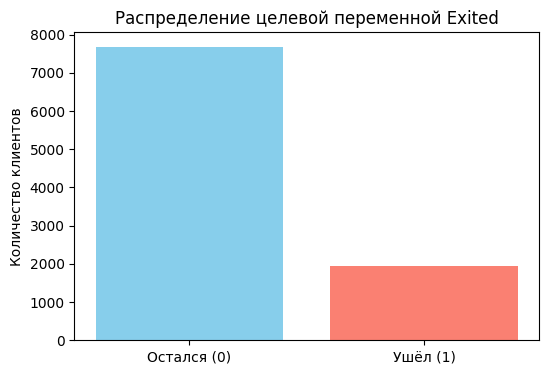

In [17]:
import matplotlib.pyplot as plt

# Подсчёт количества каждой категории
target_counts = data['Exited'].value_counts()
print("Количество записей по классам:")
print(target_counts)

# Подсчёт доли каждого класса
target_ratio = data['Exited'].value_counts(normalize=True)
print("\nДоля каждого класса:")
print(target_ratio)

# Визуализация
plt.figure(figsize=(6,4))
plt.bar(target_counts.index.astype(str), target_counts.values, color=['skyblue', 'salmon'])
plt.xticks([0,1], ['Остался (0)', 'Ушёл (1)'])
plt.ylabel('Количество клиентов')
plt.title('Распределение целевой переменной Exited')
plt.show()


> Видим, что целевая переменная сильно несбалансирована:
> - 0 (остался) → 7 677 клиентов (~80%)
> - 1 (ушёл) → 1 950 клиентов (~20%)

# 2. Обучение эталонных моделей

> Проведем разбиение данных на обучающую и тренировочную выборку.

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

# Отделяем признаки и целевую переменную
X = data.drop(columns=['Exited','Surname'])
y = data['Exited']

# Разбиение на обучающую и контрольную выборки
# test_size=0.2 → 20% данных для теста, random_state=42 для воспроизводимости
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Скалируем числовые признаки
num_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

X_train_num = pd.DataFrame(
    scaler.fit_transform(X_train[num_features]),
    columns=num_features,
    index=X_train.index
)

X_test_num = pd.DataFrame(
    scaler.transform(X_test[num_features]),
    columns=num_features,
    index=X_test.index
)

# Выбираем категориальные признаки
cat_features = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

X_train_cat = X_train[cat_features].copy()
X_test_cat  = X_test[cat_features].copy()

# Объединяем обратно
X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_test  = pd.concat([X_test_num, X_test_cat], axis=1)



# 3. Оптимизация с учетом дисбаланса

> Почитав немного Habr, натыкаемся на метод Tomek Links для борьбы с дисбалансом классов. Подход следующий, идентифицирует пары близких соседей, в которых один пример принадлежит классу меньшинства, а другой - классу большинства. После их идентификации удаляется пример из класса большинства, что помогает уменьшить дисбаланс данных.

> Сравниваем Tomek Links с Random Undersampling

Размер обучающего набора до балансировки: 7701
После Random Undersampling: 3120
После Tomek Links: 2888


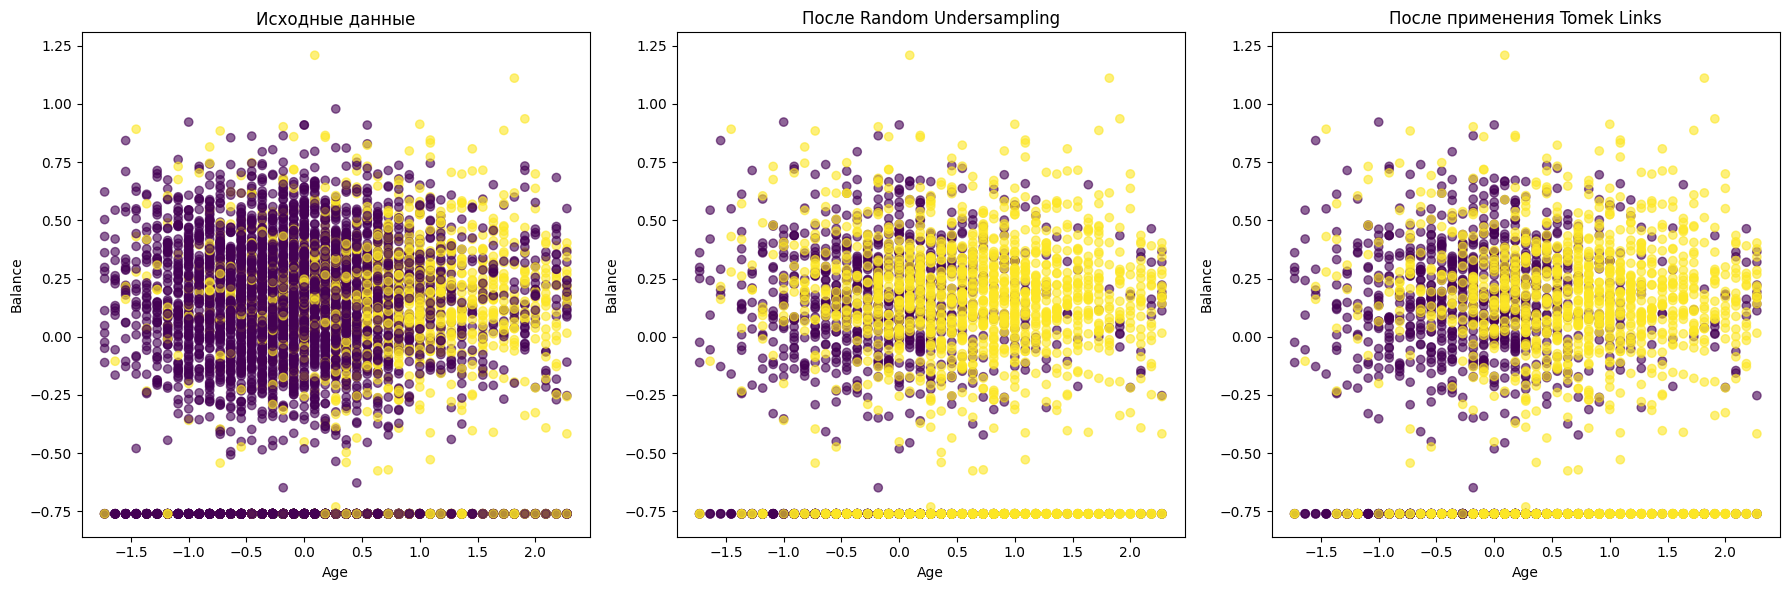

In [19]:
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Random Undersampling ---
rus = RandomUnderSampler(random_state=42)
X_res_rus, y_res_rus = rus.fit_resample(X_train, y_train)

# --- 2. Применение Tomek Links ---
tl = TomekLinks()
X_res_final, y_res_final = tl.fit_resample(X_res_rus, y_res_rus)

print(f"Размер обучающего набора до балансировки: {X_train.shape[0]}")
print(f"После Random Undersampling: {X_res_rus.shape[0]}")
print(f"После Tomek Links: {X_res_final.shape[0]}")

# --- 3. Визуализация (по признакам Age и Balance) ---

# --- Получаем индексы колонок ---
# --- Преобразуем в NumPy (если это DataFrame) ---
def to_numpy(X):
    if hasattr(X, 'values'):
        return X.values
    return X

X_train_np = to_numpy(X_train)
X_res_rus_np = to_numpy(X_res_rus)
X_res_final_np = to_numpy(X_res_final)

# --- Найдём индексы колонок для Age и Balance ---
cols = list(X_train.columns)
age_idx = cols.index('Age')
balance_idx = cols.index('Balance')

plt.figure(figsize=(18, 6))

# 1. Исходные данные
plt.subplot(1, 3, 1)
plt.scatter(X_train_np[:, age_idx], X_train_np[:, balance_idx], c=y_train, alpha=0.6)
plt.xlabel('Age')
plt.ylabel('Balance')
plt.title("Исходные данные")

# 2. После Random Undersampling
plt.subplot(1, 3, 2)
plt.scatter(X_res_rus_np[:, age_idx], X_res_rus_np[:, balance_idx], c=y_res_rus, alpha=0.6)
plt.xlabel('Age')
plt.ylabel('Balance')
plt.title("После Random Undersampling")

# 3. После Tomek Links
plt.subplot(1, 3, 3)
plt.scatter(X_res_final_np[:, age_idx], X_res_final_np[:, balance_idx], c=y_res_final, alpha=0.6)
plt.xlabel('Age')
plt.ylabel('Balance')
plt.title("После применения Tomek Links")

plt.tight_layout()
plt.show()



> Видим, что Tomek Links показал более хороший результат, хоть и данных он убрал больше

> Посмотрим распределения целевой переменной

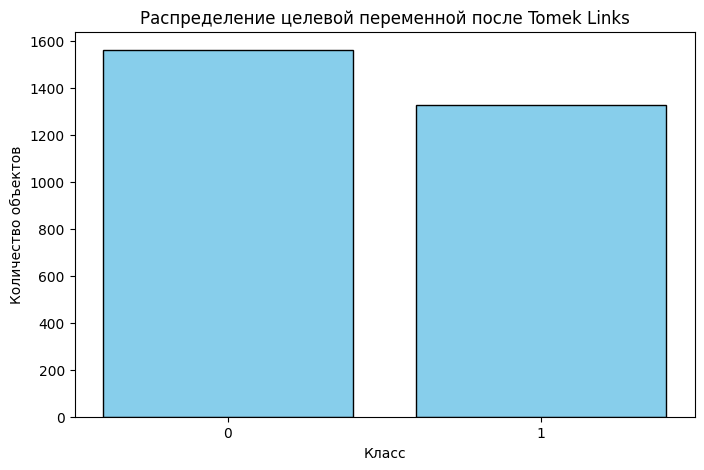

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Преобразуем y_res_final в Series (для удобства подсчёта)
y_final_series = pd.Series(y_res_final)

# Считаем количество объектов каждого класса
class_counts = y_final_series.value_counts().sort_index()

# Строим столбчатую диаграмму
plt.figure(figsize=(8, 5))
plt.bar(class_counts.index.astype(str), class_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Класс')
plt.ylabel('Количество объектов')
plt.title('Распределение целевой переменной после Tomek Links')
plt.xticks(rotation=0)
plt.show()


In [21]:
pip install catboost


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


=== CatBoost ===
Train metrics:
              precision    recall  f1-score   support

           0      0.868     0.816     0.841      1560
           1      0.798     0.854     0.825      1328

    accuracy                          0.833      2888
   macro avg      0.833     0.835     0.833      2888
weighted avg      0.836     0.833     0.834      2888

Test metrics:
              precision    recall  f1-score   support

           0      0.927     0.811     0.865      1536
           1      0.501     0.749     0.600       390

    accuracy                          0.798      1926
   macro avg      0.714     0.780     0.733      1926
weighted avg      0.841     0.798     0.811      1926

Train: Accuracy=0.833, F1=0.825, ROC AUC=0.919
Test: Accuracy=0.798, F1=0.600, ROC AUC=0.858


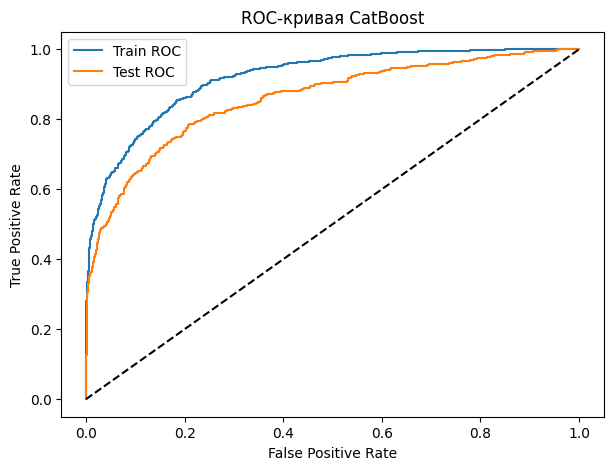

In [22]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score, accuracy_score, roc_curve
import matplotlib.pyplot as plt

# --- Модель ---
cat_model = CatBoostClassifier(
    iterations=5000,
    learning_rate=0.0005,
    depth=6,
    l2_leaf_reg=3,
    class_weights=[0.7, 1.0],
    random_seed=42,
    verbose=False
)

# --- Обучение ---
cat_model.fit(X_res_final, y_res_final)

# --- Предсказания ---
y_train_pred = cat_model.predict(X_res_final)
y_train_proba = cat_model.predict_proba(X_res_final)[:, 1]
y_test_pred = cat_model.predict(X_test)
y_test_proba = cat_model.predict_proba(X_test)[:, 1]

# --- Метрики ---
print("=== CatBoost ===")
print("Train metrics:")
print(classification_report(y_res_final, y_train_pred, digits=3))
print("Test metrics:")
print(classification_report(y_test, y_test_pred, digits=3))

print(f"Train: Accuracy={accuracy_score(y_res_final, y_train_pred):.3f}, "
      f"F1={f1_score(y_res_final, y_train_pred):.3f}, "
      f"ROC AUC={roc_auc_score(y_res_final, y_train_proba):.3f}")
print(f"Test: Accuracy={accuracy_score(y_test, y_test_pred):.3f}, "
      f"F1={f1_score(y_test, y_test_pred):.3f}, "
      f"ROC AUC={roc_auc_score(y_test, y_test_proba):.3f}")

# --- ROC-кривая ---
fpr_train, tpr_train, _ = roc_curve(y_res_final, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(7,5))
plt.plot(fpr_train, tpr_train, label='Train ROC')
plt.plot(fpr_test, tpr_test, label='Test ROC')
plt.plot([0,1],[0,1],'k--')
plt.title('ROC-кривая CatBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


# 4. Итоговое тестирование и сравнение


> Подберем гиперпараметры модели

In [23]:
import joblib
from itertools import product
from tqdm import tqdm
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

# --- Базовые параметры ---
base_params = {
    'iterations': 5000,
    'learning_rate': 0.0005,
    'depth': 6,
    'l2_leaf_reg': 3,
    'class_weights': [0.7, 1.0],
    'random_seed': 42,
    'verbose': False,
    'eval_metric': 'F1',
}

# --- Локальные диапазоны ---
param_grid = {
    'iterations': [4500, 5000, 5500],
    'learning_rate': [0.0003, 0.0005, 0.0007],
    'depth': [5, 6, 7],
    'l2_leaf_reg': [2, 3, 4],
    'class_weights': [
        [0.6, 1.0],
        [0.7, 1.0],
        [0.8, 1.0]
    ]
}

# --- Генерация комбинаций ---
param_combinations = list(product(
    param_grid['iterations'],
    param_grid['learning_rate'],
    param_grid['depth'],
    param_grid['l2_leaf_reg'],
    param_grid['class_weights']
))

print(f"Всего комбинаций: {len(param_combinations)}")

best_model = None
best_f1 = -1
best_params = None

# --- Основной цикл ---
for iterations, lr, depth, l2, weights in tqdm(param_combinations, desc="Локальный поиск"):
    params = base_params.copy()
    params.update({
        'iterations': iterations,
        'learning_rate': lr,
        'depth': depth,
        'l2_leaf_reg': l2,
        'class_weights': weights
    })

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, verbose=False)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    if f1 > best_f1:
        best_f1 = f1
        best_model = model
        best_params = params

# --- Итоги ---
print("🏆 Лучшая модель:")
print(f"Параметры: {best_params}")
print(f"F1: {best_f1:.3f}")




Всего комбинаций: 243


Локальный поиск:   1%|          | 3/243 [00:15<20:56,  5.23s/it]


KeyboardInterrupt: 

> Всего комбинаций: 243
>> Локальный поиск: 100%|██████████| 243/243 [1:31:33<00:00, 22.61s/it]🏆 Лучшая > модель:
>>> Параметры: {'iterations': 5500, 'learning_rate': 0.0007, 'depth': 6, 'l2_leaf_reg': 3, 'class_weights': [0.6, 1.0], 'random_seed': 42, 'verbose': False, 'eval_metric': 'F1'}
>>>>F1: 0.640

> Попробуем подобрать порог для минорного класса, чтобы повысить его значимость. А также проведем K-Fold Cross-Validation.

# Метод главных компонент

In [24]:
X_res_final

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Geography,Gender,HasCrCard,IsActiveMember
0,0.207407,-1.181818,0.25,0.141765,1.0,0.359358,0,0,0,1
1,-0.733333,0.181818,-0.75,0.282641,0.0,0.498322,1,1,0,1
2,0.444444,-0.090909,1.00,0.320152,0.0,-0.547773,0,1,1,1
3,0.170370,0.545455,0.75,-0.085658,1.0,-0.936886,1,1,1,0
4,-0.888889,0.000000,-1.00,0.365013,1.0,-0.164869,2,1,0,1
...,...,...,...,...,...,...,...,...,...,...
2883,-0.518519,0.909091,-1.00,0.204525,0.0,0.813346,0,0,0,0
2884,-0.103704,1.636364,-1.00,0.207891,0.0,-0.195185,1,0,1,0
2885,0.822222,1.727273,1.25,0.026544,2.0,-0.238964,1,1,1,1
2886,0.651852,0.363636,0.75,-0.759969,0.0,0.930132,2,0,1,0


In [25]:
from math import copysign
from numbers import Number
from typing import Iterable


def prod_scalar(vector_a: Iterable[Number], vector_b: Iterable[Number]) -> float:

    if len(vector_a) != len(vector_b):
        raise ValueError("Длины векторов должны совпадать для скалярного произведения")
    return float(sum(float(a) * float(b) for a, b in zip(vector_a, vector_b)))


def euclidean_norm(vector: Iterable[Number]) -> float:
    return (prod_scalar(vector, vector))**0.5


def sign(value: float) -> float:

    return 1.0 if value == 0.0 else copysign(1.0, value)

In [26]:
from __future__ import annotations
from typing import List, Tuple, Iterable, Union, Any
from copy import deepcopy
from math import sqrt


Number = Union[int, float]


class Matrix:
    def __init__(self, values: Iterable[Iterable[Number]]) -> None:
        if (
            not values
            or not isinstance(values, (list, tuple))
            or not isinstance(values[0], (list, tuple))
        ):
            raise ValueError("Данные матрицы должны быть непустым списком списков")

        row_count: int = len(values)
        col_count: int = len(values[0])

        for row in values:
            if len(row) != col_count:
                raise ValueError("Все строки матрицы должны иметь одинаковую длину")

        self._values: List[List[float]] = [
            [float(element) for element in row] for row in values
        ]
        self._row_count: int = row_count
        self._col_count: int = col_count

    @staticmethod
    def zeros(row_count: int, col_count: int) -> "Matrix":
        return Matrix([[0.0] * col_count for _ in range(row_count)])

    @staticmethod
    def eye(size: int) -> "Matrix":
        identity = Matrix.zeros(size, size)
        for index in range(size):
            identity._values[index][index] = 1.0
        return identity

    @property
    def shape(self) -> Tuple[int, int]:
        return self._row_count, self._col_count

    def copy(self) -> "Matrix":
        return Matrix(deepcopy(self._values))

    def is_square(self) -> bool:
        return self._row_count == self._col_count

    def is_symmetric(self, tolerance: float = 1e-12) -> bool:
        if not self.is_square():
            return False
        size: int = self._row_count
        for row_index in range(size):
            for col_index in range(row_index + 1, size):
                if abs(self._values[row_index][col_index] - self._values[col_index][row_index]) > tolerance:
                    return False
        return True

    def __getitem__(self, row_index: int) -> List[float]:
        return self._values[row_index]

    def __setitem__(self, row_index: int, new_row: Iterable[Number]) -> None:

        if len(new_row) != self._col_count:
            raise ValueError("Длина строки не совпадает с числом столбцов")

        self._values[row_index] = [float(element) for element in new_row]

    def __add__(self, other: Union["Matrix", Number]) -> "Matrix":
        if isinstance(other, Matrix):
            self_rows, self_cols = self.shape
            other_rows, other_cols = other.shape
            if (self_rows, self_cols) != (other_rows, other_cols):
                raise ValueError("Размеры матриц не совпадают для сложения")
            return Matrix(
                [
                    [self._values[row_index][col_index] + other._values[row_index][col_index] for col_index in range(self_cols)]
                    for row_index in range(self_rows)
                ]
            )
        elif isinstance(other, (int, float)):
            self_rows, self_cols = self.shape
            return Matrix(
                [
                    [self._values[row_index][col_index] + float(other) for col_index in range(self_cols)]
                    for row_index in range(self_rows)
                ]
            )
        else:
            raise TypeError("Поддерживается сложение только с Matrix или числом")

    def __sub__(self, other: Union["Matrix", Number]) -> "Matrix":
        if isinstance(other, Matrix):
            self_rows, self_cols = self.shape
            other_rows, other_cols = other.shape
            if (self_rows, self_cols) != (other_rows, other_cols):
                raise ValueError("Размеры матриц не совпадают для вычитания")
            return Matrix(
                [
                    [self._values[row_index][col_index] - other._values[row_index][col_index] for col_index in range(self_cols)]
                    for row_index in range(self_rows)
                ]
            )
        elif isinstance(other, (int, float)):
            self_rows, self_cols = self.shape
            return Matrix(
                [
                    [self._values[row_index][col_index] - float(other) for col_index in range(self_cols)]
                    for row_index in range(self_rows)
                ]
            )
        else:
            raise TypeError("Поддерживается вычитание только с Matrix или числом")

    def __rmul__(self, other: Number) -> "Matrix":
        return self.__mul__(other)

    def __mul__(self, other: Union["Matrix", Number]) -> "Matrix":
        if isinstance(other, (int, float)):
            row_count, col_count = self.shape
            factor = float(other)
            return Matrix(
                [
                    [self._values[row_index][col_index] * factor for col_index in range(col_count)]
                    for row_index in range(row_count)
                ]
            )
        elif isinstance(other, Matrix):
            left_rows, left_cols = self.shape
            right_rows, right_cols = other.shape
            if left_cols != right_rows:
                raise ValueError("Формы матриц несовместимы для умножения")
            result = Matrix.zeros(left_rows, right_cols)
            for row_index in range(left_rows):
                for common_index in range(left_cols):
                    left_value = self._values[row_index][common_index]
                    if left_value == 0.0:
                        continue
                    result_row = result._values[row_index]
                    other_row = other._values[common_index]
                    for col_index in range(right_cols):
                        result_row[col_index] += left_value * other_row[col_index]
            return result
        else:
            raise TypeError("Поддерживается умножение только с Matrix или числом")

    def transposed(self) -> "Matrix":
        row_count, col_count = self.shape
        return Matrix([[self._values[row_index][col_index] for row_index in range(row_count)] for col_index in range(col_count)])

    @staticmethod
    def outer(vector_left: Iterable[Number], vector_right: Iterable[Number]) -> "Matrix":
        return Matrix(
            [
                [float(vector_left[row_index]) * float(vector_right[col_index]) for col_index in range(len(vector_right))]
                for row_index in range(len(vector_left))
            ]
        )

    def norm(self) -> float:
        squared_sum: float = 0.0
        for row in self._values:
            for value in row:
                squared_sum += value * value
        return sqrt(squared_sum)

    def diagonal(self) -> List[float]:
        if not self.is_square():
            raise ValueError("Диагональ определена только для квадратных матриц")
        return [self._values[index][index] for index in range(self._row_count)]

    def __repr__(self) -> str:
        return str(self)

    def __str__(self) -> str:
        formatted_rows: List[str] = []
        for row in self._values:
            formatted_rows.append("[" + "  ".join(f"{value: .6g}" for value in row) + "]")
        return "\n".join(formatted_rows)

In [27]:
from typing import Tuple, Union



def qr_decomposition_householder(matrix: "Matrix") -> Tuple["Matrix", "Matrix"]:
    """
    QR-разложение матрицы методом отражений Хаусхолдера

    :return: tuple(Q, R), где Q — (n x n), R — (n x m).
    """

    r_matrix: Matrix = matrix.copy()
    row_count, col_count = r_matrix.shape
    q_matrix: Matrix = Matrix.eye(row_count)

    for pivot_index in range(min(row_count, col_count) - 1):
        # Берём столбец pivot_index, начиная с строки pivot_index
        column_tail: list[float] = [r_matrix[row_index][pivot_index] for row_index in range(pivot_index, row_count)]
        column_tail_norm: float = euclidean_norm(column_tail)
        if column_tail_norm == 0.0:
            continue

        unit_first: list[float] = [0.0] * (row_count - pivot_index)
        unit_first[0] = 1.0

        alpha_value: float = sign(column_tail[0]) * column_tail_norm

        # u = x + alpha * e1
        householder_raw: list[float] = [
            column_tail[idx] + alpha_value * unit_first[idx] for idx in range(row_count - pivot_index)
        ]
        householder_norm: float = euclidean_norm(householder_raw)
        if householder_norm == 0.0:
            continue

        # v = u / ||u||
        householder_vector: list[float] = [component / householder_norm for component in householder_raw]

        reflector_full: list[float] = [0.0] * row_count
        for local_index, value in enumerate(householder_vector):
            reflector_full[pivot_index + local_index] = value

        # Матрица отражения H = I - 2 * v v^T
        identity_matrix: Matrix = Matrix.eye(row_count)
        outer_product: Matrix = Matrix.outer(reflector_full, reflector_full)
        householder_matrix: Matrix = identity_matrix - (2.0 * outer_product)

        r_matrix = householder_matrix * r_matrix
        q_matrix = q_matrix * householder_matrix

    return q_matrix, r_matrix


def qr_algorithm(
    matrix: "Matrix",
    max_iterations: int = 1000,
    tolerance: float = 1e-12,
    return_eigenvectors: bool = False
) -> Tuple[list[float], Matrix | None]:
    """
    QR-алгоритм без сдвигов для приближённого нахождения собственных значений
    """
    if not matrix.is_square():
        raise ValueError("QR-алгоритм требует квадратную матрицу")

    size, _ = matrix.shape
    iterated_matrix: Matrix = matrix.copy()
    eigenvectors_matrix: Matrix = Matrix.eye(size)

    for _iteration_index in range(max_iterations):
        q_matrix, r_matrix = qr_decomposition_householder(iterated_matrix)
        iterated_matrix = r_matrix * q_matrix

        eigenvectors_matrix = eigenvectors_matrix * q_matrix

        sum_of_squares_offdiag: float = 0.0
        for row_index in range(size):
            for col_index in range(0, row_index):
                value = iterated_matrix[row_index][col_index]
                sum_of_squares_offdiag += value * value
        offdiag_norm: float = sum_of_squares_offdiag**0.5
        if offdiag_norm < tolerance:
            break

    eigenvalues: list[float] = iterated_matrix.diagonal()

    if return_eigenvectors and matrix.is_symmetric():
        normalized_vectors: Matrix = eigenvectors_matrix.copy()
        for col_index in range(size):
            column_values: list[float] = [normalized_vectors[row_index][col_index] for row_index in range(size)]
            column_norm: float = euclidean_norm(column_values)
            if column_norm != 0.0:
                inv_norm: float = 1.0 / column_norm
                for row_index in range(size):
                    normalized_vectors[row_index][col_index] *= inv_norm
        return eigenvalues, normalized_vectors

    return eigenvalues, None

In [28]:

if __name__ == "__main__":
    A = Matrix([
        [4.0, 1.0, 1.0],
        [1.0, 3.0, 0.0],
        [1.0, 0.0, 2.0],
    ])

    vals, _ = qr_algorithm(A)
    print("Eigenvectors:", vals)

    vals2, vecs = qr_algorithm(A, return_eigenvectors=True)
    print("Eigenvalues (sym):", vals)
    print("Eigenvectors (columns):\n", vecs)

Eigenvectors: [4.87938524157182, 2.6527036446661287, 1.4679111137620435]
Eigenvalues (sym): [4.87938524157182, 2.6527036446661287, 1.4679111137620435]
Eigenvectors (columns):
 [-0.84403   0.293128  -0.449099]
[-0.449099  -0.84403   0.293128]
[-0.293128   0.449099   0.84403]


In [29]:
# 1. Центрирование данных (списки списков)
def center_data(X):
    n_rows = len(X)
    n_cols = len(X[0])
    means = [sum(X[i][j] for i in range(n_rows))/n_rows for j in range(n_cols)]
    X_centered = [[X[i][j] - means[j] for j in range(n_cols)] for i in range(n_rows)]
    return X_centered, means

# 2. Ковариационная матрица
def covariance_matrix(X_centered):
    n_rows = len(X_centered)
    n_cols = len(X_centered[0])
    cov = [[0.0]*n_cols for _ in range(n_cols)]
    for i in range(n_cols):
        for j in range(n_cols):
            s = sum(X_centered[k][i] * X_centered[k][j] for k in range(n_rows))
            cov[i][j] = s / (n_rows - 1)
    return cov

# 3. Применение qr_algorithm
def pca_qr(X):
    X_centered, means = center_data(X)
    cov = covariance_matrix(X_centered)
    A = Matrix(cov)

    # Получаем собственные значения и векторы
    eigvals, eigvecs = qr_algorithm(A, return_eigenvectors=True)

    # Доля объяснённой дисперсии
    total_variance = sum(eigvals)
    explained_ratio = [v / total_variance for v in eigvals]

    # Преобразование данных в главные компоненты
    # X_pca = X_centered @ eigvecs (на списках)
    n_rows = len(X_centered)
    n_cols = len(X_centered[0])
    X_pca = [[sum(X_centered[i][k] * eigvecs[k][j] for k in range(n_cols))
              for j in range(n_cols)] for i in range(n_rows)]

    return eigvals, eigvecs, explained_ratio, X_pca

In [30]:
# Преобразуем DataFrame в список списков
X_list = X_res_final.values.tolist()

# Центрирование
X_centered, means = center_data(X_list)

# Ковариация
cov = covariance_matrix(X_centered)

# QR-алгоритм
A = Matrix(cov)
eigvals, eigvecs = qr_algorithm(A, return_eigenvectors=True)

# Объяснённая дисперсия
total_var = sum(eigvals)
explained_ratio = [v / total_var for v in eigvals]

# Проекция на главные компоненты
n_rows = len(X_centered)
n_cols = len(X_centered[0])
X_pca = [[sum(X_centered[i][k] * eigvecs[k][j] for k in range(n_cols))
          for j in range(n_cols)] for i in range(n_rows)]

X_pca

[[1.4911703059627484,
  0.7712114617702126,
  -0.22613806427132316,
  0.2231265316329792,
  0.1336524359229869,
  0.34161125537285647,
  0.03287598030448368,
  0.8378993559725909,
  -0.6697214837538028,
  -0.41193399345298765],
 [-0.03196090043170377,
  -0.29232160258566037,
  1.0582123253287894,
  -0.5363708235963455,
  -0.09294504460471593,
  0.4834930242934566,
  -0.7630561955723976,
  0.2825315187089764,
  -0.403559791692156,
  -0.5601577236987128],
 [0.35172553980082716,
  0.7905419087697917,
  -0.5546764973995358,
  0.18748341230976273,
  -1.0733405276452714,
  -0.7102730560339312,
  -0.6788218568668235,
  0.10649753378542205,
  -0.2867518130226816,
  0.29809583554423325],
 [-0.15632497861662234,
  -0.2194569084674583,
  -0.5173958003969221,
  0.6614177736348771,
  -0.06411970159139817,
  -1.0356195273558608,
  0.004486163302478741,
  -0.7091798950969016,
  -0.04023213069849676,
  0.10558270162517192],
 [0.2549238751356752,
  -1.3313090326289005,
  1.0977122627365676,
  -0.236386

In [31]:
import pandas as pd

# X_pca — это список списков, размерность (n_rows, n_cols)
n_cols = len(X_pca[0])

# Создаём имена колонок для главных компонент
pc_columns = [f'PC{i+1}' for i in range(n_cols)]

# Превращаем в DataFrame
X_pca_df = pd.DataFrame(X_pca, columns=pc_columns)

# Если хочешь сохранить индексы исходного DataFrame
X_pca_df.index = X_res_final.index

# Проверка
display(X_pca_df.head())

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,1.491170,0.771211,-0.226138,0.223127,0.133652,0.341611,0.032876,0.837899,-0.669721,-0.411934
1,-0.031961,-0.292322,1.058212,-0.536371,-0.092945,0.483493,-0.763056,0.282532,-0.403560,-0.560158
2,0.351726,0.790542,-0.554676,0.187483,-1.073341,-0.710273,-0.678822,0.106498,-0.286752,0.298096
3,-0.156325,-0.219457,-0.517396,0.661418,-0.064120,-1.035620,0.004486,-0.709180,-0.040232,0.105583
4,0.254924,-1.331309,1.097712,-0.236386,0.781233,-0.180639,-0.645583,0.194416,-0.688860,-0.490900



===== MODEL PERFORMANCE =====
Set            Accuracy    F1 Score    ROC AUC     
--------------------------------------------------
Train          0.804       0.810       0.905       
Validation     0.773       0.795       0.886       
Test           0.740       0.735       0.857       
--------------------------------------------------

--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

           0      0.837     0.673     0.746       327
           1      0.660     0.829     0.735       251

    accuracy                          0.740       578
   macro avg      0.748     0.751     0.740       578
weighted avg      0.760     0.740     0.741       578



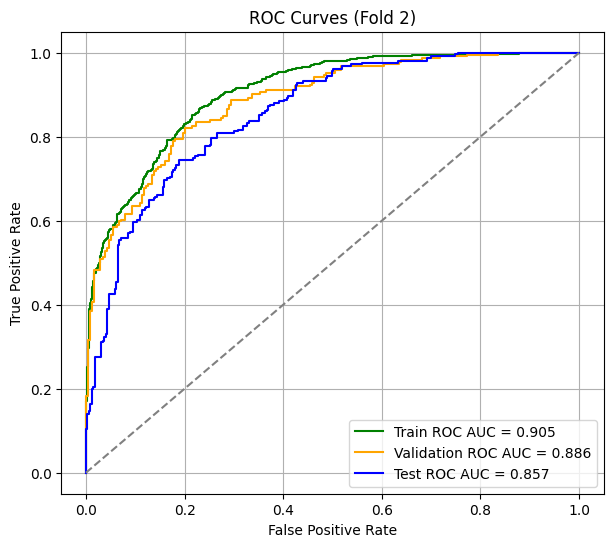

In [35]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, classification_report, roc_curve
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier

# --- Параметры ---
best_model_fold = 2
best_model_thresh = 0.465

# --- Инициализация модели ---
cat_model = CatBoostClassifier(
    iterations=5500,
    learning_rate=0.0007,
    depth=6,
    l2_leaf_reg=3,
    class_weights=[0.6, 1.0],
    random_seed=42,
    eval_metric='F1',
    verbose=0  # без вывода обучения
)

# --- K-Fold ---
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# --- Получаем данные выбранного фолда ---
fold = 1
for train_idx, test_idx in kfold.split(X_pca_df, y_res_final):
    if fold == best_model_fold:
        X_train_fold, X_test_fold = X_pca_df.iloc[train_idx], X_pca_df.iloc[test_idx]
        y_train_fold, y_test_fold = y_res_final.iloc[train_idx], y_res_final.iloc[test_idx]
        break
    fold += 1

# --- Делим тренировочные данные на train/validation ---
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_fold, y_train_fold, test_size=0.2, random_state=42
)

# --- Обучение без вывода ---
cat_model.fit(X_train_split, y_train_split, eval_set=(X_val_split, y_val_split), verbose=0)

# --- Предсказания ---
y_proba_train = cat_model.predict_proba(X_train_split)[:, 1]
y_proba_val   = cat_model.predict_proba(X_val_split)[:, 1]
y_proba_test  = cat_model.predict_proba(X_test_fold)[:, 1]

# --- Применяем порог ---
y_pred_train = (y_proba_train >= best_model_thresh).astype(int)
y_pred_val   = (y_proba_val >= best_model_thresh).astype(int)
y_pred_test  = (y_proba_test >= best_model_thresh).astype(int)

# --- Функция для вывода метрик ---
def get_metrics(y_true, y_pred, y_proba):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "ROC AUC": roc_auc_score(y_true, y_proba)
    }

# --- Считаем метрики ---
metrics_train = get_metrics(y_train_split, y_pred_train, y_proba_train)
metrics_val   = get_metrics(y_val_split, y_pred_val, y_proba_val)
metrics_test  = get_metrics(y_test_fold, y_pred_test, y_proba_test)

# --- Печатаем метрики красиво ---
print("\n===== MODEL PERFORMANCE =====")
print(f"{'Set':<15}{'Accuracy':<12}{'F1 Score':<12}{'ROC AUC':<12}")
print("-" * 50)
print(f"{'Train':<15}{metrics_train['Accuracy']:<12.3f}{metrics_train['F1 Score']:<12.3f}{metrics_train['ROC AUC']:<12.3f}")
print(f"{'Validation':<15}{metrics_val['Accuracy']:<12.3f}{metrics_val['F1 Score']:<12.3f}{metrics_val['ROC AUC']:<12.3f}")
print(f"{'Test':<15}{metrics_test['Accuracy']:<12.3f}{metrics_test['F1 Score']:<12.3f}{metrics_test['ROC AUC']:<12.3f}")
print("-" * 50)

# --- Дополнительно выводим подробный classification_report ---
print("\n--- Classification Report (Test Set) ---")
print(classification_report(y_test_fold, y_pred_test, digits=3))

# --- ROC-кривые ---
fpr_train, tpr_train, _ = roc_curve(y_train_split, y_proba_train)
fpr_val, tpr_val, _     = roc_curve(y_val_split, y_proba_val)
fpr_test, tpr_test, _   = roc_curve(y_test_fold, y_proba_test)

plt.figure(figsize=(7,6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC AUC = {metrics_train["ROC AUC"]:.3f}', color='green')
plt.plot(fpr_val, tpr_val, label=f'Validation ROC AUC = {metrics_val["ROC AUC"]:.3f}', color='orange')
plt.plot(fpr_test, tpr_test, label=f'Test ROC AUC = {metrics_test["ROC AUC"]:.3f}', color='blue')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves (Fold {best_model_fold})')
plt.legend()
plt.grid(True)
plt.show()
